In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys
import xgboost as xgb
import datetime
import time
import operator

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
ids = test.Id

mapping = {'Front':0, 'Right':1, 'Left':2, 'Rear':3}
train = train.replace({'DetectedCamera':mapping})
test = test.replace({'DetectedCamera':mapping})

#renaming column
train.rename(columns = {'SignFacing (Target)': 'Target'}, inplace=True)

#encode Target Variable based on sample submission file
mapping = {'Front':0, 'Left':1, 'Rear':2, 'Right':3}
train = train.replace({'Target':mapping})
train.head()

,Id,DetectedCamera,AngleOfSign,SignAspectRatio,SignWidth,SignHeight,Target
0,2c9180975a056a64015a1e0a52e57021,3,195,1.02,46,45,2
1,2c9180975a056a64015a1e17b32171e4,3,203,1.09,59,54,2
2,2c9180975a056a64015a1de4deb16bd5,0,26,0.96,104,108,0
3,2c9180975a056a64015a1de4deb16bdd,3,199,0.81,38,47,2
4,2c9180975a056a64015a1de4deb16bd6,3,208,0.93,54,58,2


In [8]:
train['SignArea'] = train['SignWidth'] * train['SignHeight']
test['SignArea'] = test['SignWidth'] * test['SignHeight']
train['SignPeri'] = train['SignWidth'] + train['SignHeight']
test['SignPeri'] = test['SignWidth'] + test['SignHeight']
train.head()

,Id,DetectedCamera,AngleOfSign,SignAspectRatio,SignWidth,SignHeight,Target,SignArea,SignPeri
0,2c9180975a056a64015a1e0a52e57021,3,195,1.02,46,45,2,2070,91
1,2c9180975a056a64015a1e17b32171e4,3,203,1.09,59,54,2,3186,113
2,2c9180975a056a64015a1de4deb16bd5,0,26,0.96,104,108,0,11232,212
3,2c9180975a056a64015a1de4deb16bdd,3,199,0.81,38,47,2,1786,85
4,2c9180975a056a64015a1de4deb16bd6,3,208,0.93,54,58,2,3132,112


In [9]:
target = train['Target']
train = train.drop(['Target', 'Id'], axis=1)
test.drop('Id',inplace=True,axis=1)

In [10]:
def score(params):
    print ("Training with params : ")
    print (params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score =   log_loss( y_test, predictions) 
    print ("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [11]:
def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1500, 1),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.choice('max_depth', np.arange(1, 13, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1), 
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'alpha' : hp.quniform('alpha', 0, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'eval_metric': 'mlogloss',
             'objective': 'multi:softprob',
             'num_class' : 4,
             'nthread' : 6,
             'silent' : 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals= 500)
    print (best)

In [12]:
X, y = train, target
print ("Splitting data into train and valid ...\n\n")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape )

Splitting data into train and valid ...


(30788, 7) (7697, 7) (30788,) (7697,)


In [8]:
#Trials object where the history of search will be stored
trials = Trials()
optimize(trials)

Training with params : 
{'objective': 'multi:softprob', 'num_class': 4, 'subsample': 0.9500000000000001, 'n_estimators': 882.0, 'eval_metric': 'mlogloss', 'eta': 0.47500000000000003, 'nthread': 6, 'colsample_bytree': 0.8, 'max_depth': 3, 'alpha': 0.35000000000000003, 'min_child_weight': 4.0, 'gamma': 0.7000000000000001, 'silent': 1}
	Score 0.11924749069079894


Training with params : 
{'objective': 'multi:softprob', 'num_class': 4, 'subsample': 0.7000000000000001, 'n_estimators': 713.0, 'eval_metric': 'mlogloss', 'eta': 0.07500000000000001, 'nthread': 6, 'colsample_bytree': 1.0, 'max_depth': 10, 'alpha': 0.55, 'min_child_weight': 2.0, 'gamma': 0.75, 'silent': 1}
	Score 0.12408606705082673


Training with params : 
{'objective': 'multi:softprob', 'num_class': 4, 'subsample': 0.8, 'n_estimators': 1475.0, 'eval_metric': 'mlogloss', 'eta': 0.17500000000000002, 'nthread': 6, 'colsample_bytree': 0.55, 'max_depth': 8, 'alpha': 0.05, 'min_child_weight': 5.0, 'gamma': 0.8, 'silent': 1}
	Score 0

In [9]:
results = trials.best_trial['misc']['vals']
results

{'alpha': [0.9],
 'colsample_bytree': [1.0],
 'eta': [0.07500000000000001],
 'gamma': [0.9500000000000001],
 'max_depth': [3],
 'min_child_weight': [3.0],
 'n_estimators': [142.0],
 'subsample': [0.9500000000000001]}

In [35]:
params = {'objective': 'multi:softprob',
          'booster': 'gbtree',
          'eval_metric' : 'mlogloss',
          'nthread': 4,
          'silent': 1,
          'gamma': 0.9500000000000001,
          'alpha': 0.9,
          'num_class' : 4,
          'min_child_weight': 3.0,
          'max_depth': 3,
          'subsample': 0.9500000000000001,
          "colsample_bytree": 1.0,
          'eta': 0.07500000000000001,
          'verbose_eval': True,
          'seed': 0}

In [37]:
X, y = train, target
dtrain = xgb.DMatrix(X, label= y )
dtest = xgb.DMatrix(test)
num_rounds = 2000
cv_output = xgb.cv(params, dtrain, num_boost_round=num_rounds, early_stopping_rounds=10, verbose_eval=20, show_stdv=False)

[0]	train-mlogloss:1.25258	test-mlogloss:1.25282
[20]	train-mlogloss:0.309275	test-mlogloss:0.311644
[40]	train-mlogloss:0.147285	test-mlogloss:0.151308
[60]	train-mlogloss:0.1127	test-mlogloss:0.118135
[80]	train-mlogloss:0.103601	test-mlogloss:0.110269
[100]	train-mlogloss:0.100036	test-mlogloss:0.107779
[120]	train-mlogloss:0.097666	test-mlogloss:0.106692
[140]	train-mlogloss:0.0956753	test-mlogloss:0.106056
[160]	train-mlogloss:0.0939183	test-mlogloss:0.105624
[180]	train-mlogloss:0.092418	test-mlogloss:0.105272
[200]	train-mlogloss:0.0913397	test-mlogloss:0.105217
[220]	train-mlogloss:0.090296	test-mlogloss:0.105151
[240]	train-mlogloss:0.0893537	test-mlogloss:0.105082
[260]	train-mlogloss:0.0885067	test-mlogloss:0.105025


In [47]:
num_rounds = len(cv_output)
watchlist = [(dtrain, 'dtrain')]
t1= time.time()
clf_xgb_main = xgb.train(dtrain=dtrain, params=params, num_boost_round=num_rounds, evals=watchlist, verbose_eval=20)
preds_price = clf_xgb_main.predict(dtest)
time.time() - t1

[0]	dtrain-mlogloss:1.25262
[20]	dtrain-mlogloss:0.309792
[40]	dtrain-mlogloss:0.148108
[60]	dtrain-mlogloss:0.113623
[80]	dtrain-mlogloss:0.104832
[100]	dtrain-mlogloss:0.101425
[120]	dtrain-mlogloss:0.099365
[140]	dtrain-mlogloss:0.097488
[160]	dtrain-mlogloss:0.095968
[180]	dtrain-mlogloss:0.094718
[200]	dtrain-mlogloss:0.093571
[220]	dtrain-mlogloss:0.092674
[240]	dtrain-mlogloss:0.091762
[260]	dtrain-mlogloss:0.091048


8.676063060760498

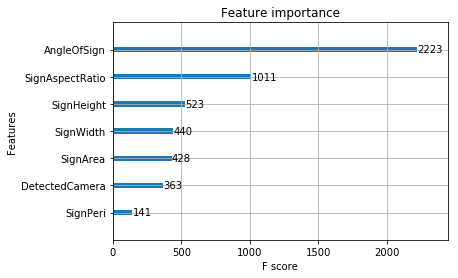

In [40]:
xgb.plot_importance(clf_xgb_main)

In [25]:
preds_price = np.zeros( (len(test), 4) )
count = 1
for s in np.random.randint(0, 1000000, size=50):
    params['seed'] = s
    t1= time.time()
    clf_xgb_main = xgb.train(dtrain=dtrain, params=params, num_boost_round=num_rounds, \
                             evals=watchlist,verbose_eval= 100)
    preds_price += clf_xgb_main.predict(dtest)
    print (count, time.time() - t1)
    count = count +1
preds_price = preds_price/50

[0]	dtrain-mlogloss:1.25268
[100]	dtrain-mlogloss:0.101395
[200]	dtrain-mlogloss:0.093806
[300]	dtrain-mlogloss:0.09085
[400]	dtrain-mlogloss:0.088991
[500]	dtrain-mlogloss:0.087545
[600]	dtrain-mlogloss:0.086495
[700]	dtrain-mlogloss:0.085639
[800]	dtrain-mlogloss:0.084912
[900]	dtrain-mlogloss:0.084133
[1000]	dtrain-mlogloss:0.083477
[1100]	dtrain-mlogloss:0.083004
[1200]	dtrain-mlogloss:0.082565
[1300]	dtrain-mlogloss:0.082149
[1400]	dtrain-mlogloss:0.081736
[1500]	dtrain-mlogloss:0.081389
[1600]	dtrain-mlogloss:0.081033
[1700]	dtrain-mlogloss:0.080678
[1800]	dtrain-mlogloss:0.080421
[1900]	dtrain-mlogloss:0.080168
1 58.912219524383545
[0]	dtrain-mlogloss:1.25263
[100]	dtrain-mlogloss:0.101444
[200]	dtrain-mlogloss:0.093897
[300]	dtrain-mlogloss:0.090859
[400]	dtrain-mlogloss:0.088949
[500]	dtrain-mlogloss:0.087435
[600]	dtrain-mlogloss:0.086262
[700]	dtrain-mlogloss:0.085245
[800]	dtrain-mlogloss:0.084541
[900]	dtrain-mlogloss:0.083852
[1000]	dtrain-mlogloss:0.083293
[1100]	dtrain-

In [48]:
#write submission file and submit
columns = ['Front','Left','Rear','Right']
sub = pd.DataFrame(data=preds_price, columns=columns)
sub['Id'] = ids
sub = sub[['Id','Front','Left','Rear','Right']]
sub.to_csv("sub_xgboost_factor_ffeat_20June.csv", index=False)